In [264]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import random

# 1次元GMM

[]

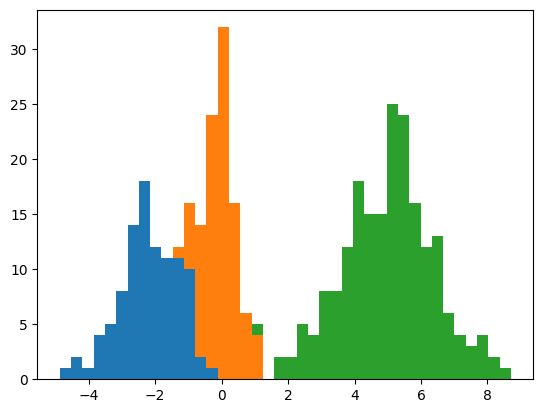

In [265]:
mean = [-2., 0., 5.]
var = [1., 0.5, 1.5]
samples = [100, 100, 200]

rng = np.random.default_rng()
d0 = pd.DataFrame({'data':rng.normal(mean[0], var[0], samples[0])})
d1 = pd.DataFrame({'data':rng.normal(mean[1], var[1], samples[1])})
d2 = pd.DataFrame({'data':rng.normal(mean[2], var[2], samples[2])})
d0['label'] = 0
d1['label'] = 1
d2['label'] = 2

X = pd.concat([d0['data'], d1['data'], d2['data']], ignore_index=True)
Y = pd.concat([d0['label'], d1['label'], d2['label']], ignore_index=True)
plt.hist([X[Y==0], X[Y==1], X[Y==2]], stacked=True, bins=40 ,label=Y)
plt.plot()

In [266]:
# parameters
K = 3
T = 100
EPSILON = 0.01

In [267]:
def gaussian_value(x, mu, sigma):
    return np.exp(-(x-mu)**2 / (2.*sigma)) / np.sqrt(2.*np.pi*sigma)

In [268]:
def initialize(x):
    return random.sample(list(x), K)

In [269]:
def E_step(x, mu, sigma, mix_co):
    gamma = []
    for n in range(len(list(x))):
        densities = []
        for k in range(K):
            gamma_nk = mix_co[k] * gaussian_value(x[n], mu[k], sigma[k])
            densities.append(gamma_nk)
        gamma_nk = densities / np.sum(densities)
        gamma.append(gamma_nk)
    gamma = pd.DataFrame(gamma) # データごとの負担率(NxK)
    return gamma

In [270]:
def M_step(x, mu, gamma):
    N_k = gamma.sum()
    weighted_sum = [0]*K # クラスターごとのx_nの重みつき平均
    weighted_var = [0]*K # クラスターごとの分散共分散の重みつき平均
    for k in range(K):
        for n in range(len(list(x))):
            weighted_sum[k] += gamma.loc[n,k] * x[n]
            weighted_var[k] += gamma.loc[n,k] * (x[n] - mu[k])**2

    mu_new = []
    sigma = []
    mix_co = list(np.array(N_k) / len(list(x)))
    for k in range(K):
        mu_new.append(weighted_sum[k] / N_k[k])
        sigma.append(weighted_var[k] / N_k[k])
    return mu_new, sigma, mix_co

In [271]:
def EM(x):
    mu = initialize(x)
    print(f"initial mean:{mu}")
    sigma = [3]*3
    mix_co = [0.33]*3
    likelihood = -np.inf
    for t in range(T):
        gamma = E_step(x, mu, sigma, mix_co)
        mu_new, sigma_new, mix_co_new = M_step(x, mu, gamma)
        # 収束確認
        likelihood_new = 0
        for n in range(len(list(x))):
            for k in range(K):
                likelihood_new += gamma.loc[n,k] * np.log(mix_co_new[k] * gaussian_value(x[n], mu_new[k], sigma_new[k]))
        if (t%5==0):
            print(f"t={t} -> likelihood: {likelihood_new}")
        if (likelihood_new - likelihood < EPSILON):
            break
        mu = mu_new
        sigma = sigma_new
        mix_co = mix_co_new
        likelihood = likelihood_new

    print(f"cycle count: {t+1}")
    return mu, sigma

In [272]:
mu, sigma = EM(X)
print(f"estimated mean: {mu}")
print(f"estimated variance: {sigma}")

initial mean:[-1.4595361902887092, 6.036519807255709, 5.795998941601807]
t=0 -> likelihood: -1112.3654551308905
t=5 -> likelihood: -1095.7777897739797
cycle count: 6
estimated mean: [-1.0288737187192405, 5.1370871445757205, 5.042660139185893]
estimated variance: [1.895033364353497, 1.7077842989410539, 1.6585938947579248]


# 2次元GMM

In [273]:
means = np.array([
    [0, 3],
    [-2, -1],
    [3, -2]
    ])
covs = np.array([
    [[1, -0.4], [-0.4, 1]],
    [[1.5, 0.3], [0.3, 1.5]],
    [[1, 0.5], [0.5, 0.6]]
    ])
sample_size = 200
K = 3 # クラスター数
D = 2 # 観測データの次元

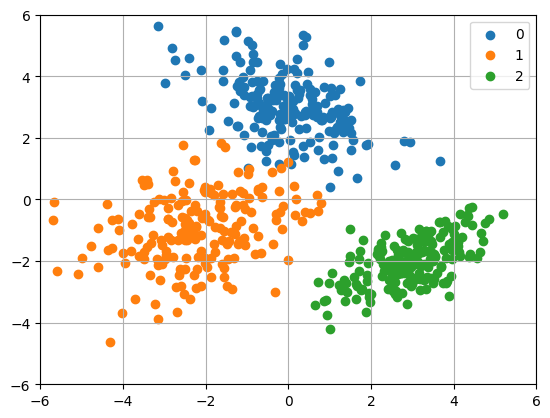

In [274]:
# numpy
# fig, ax = plt.subplots()
# data_np = np.zeros((1, 3))
# for i in range(K):
#     data_1 = np.random.multivariate_normal(means[i], covs[i], size=sample_size)
#     data_1 = np.concatenate((data_1, np.full((sample_size, 1), i)), axis=1)
#     data_np = np.concatenate((data_np, data_1))
#     ax.scatter(data_1[:,0], data_1[:,1], color=matplotlib.cm.tab10(i), label=i)
# plt.show()
# data_np = data_np[1:, :]

#scipy
fig, ax = plt.subplots()
data = np.zeros((1, 2))
cluster_label = np.zeros((1, 1), dtype=int)
for i in range(K):
    data_1 = multivariate_normal(means[i], covs[i]).rvs(size=sample_size)
    data = np.concatenate((data, data_1))
    cluster_label = np.concatenate((cluster_label, np.full((sample_size, 1), i)))
    ax.scatter(data_1[:,0], data_1[:,1], color=matplotlib.cm.tab10(i), label=i)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid()
plt.legend()
plt.show()
data = pd.DataFrame(data[1:, :]) # サンプル点の座標
cluster_label = pd.DataFrame(cluster_label[1:, :]) # サンプル点のクラスター番号

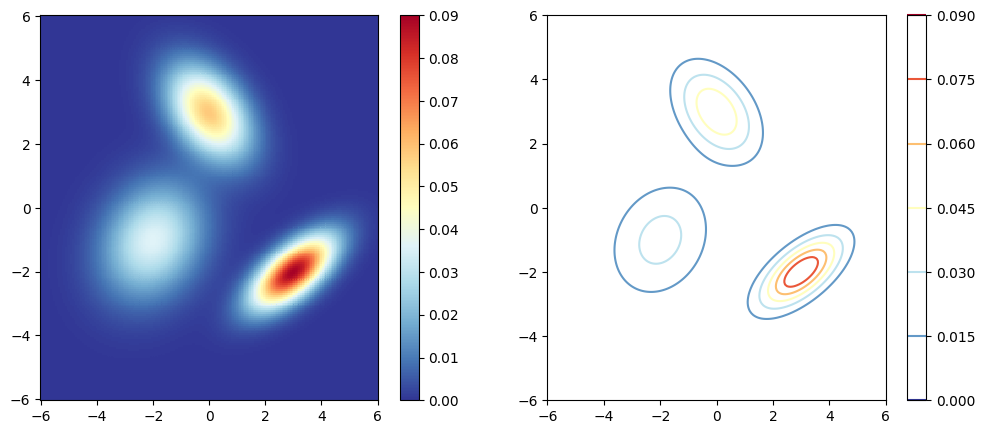

In [275]:
# 確率密度関数の可視化
posx, posy = np.mgrid[-6:6:200j, -6:6:200j]
pos = np.dstack((posx, posy))
z = 0
for k in range(K):
    z += multivariate_normal(means[k], covs[k]).pdf(pos) / K

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.pcolor(posx, posy, z, vmin=0., vmax=0.09, cmap="RdYlBu_r")
plt.colorbar()

plt.subplot(122)
plt.contour(posx, posy, z, cmap="RdYlBu_r")
plt.colorbar()
plt.show()

In [276]:
def gaussian_value(xn, mu, sigma):
    return multivariate_normal(mu, sigma).pdf(xn)

In [277]:
def initialize(x):
    idx = random.sample(range(0, len(x)), K)
    res = []
    for i in idx:
        res.append(x.loc[i, :])
    return np.array(res)

In [278]:
print(initialize(data))

[[-2.47508677 -0.01396928]
 [-0.97631942  5.13570219]
 [ 1.19655383  0.93711466]]


In [279]:
def E_step(x: pd.DataFrame, mu, sigma, mix_co):
    N = len(x)
    gamma = []
    for n in range(N):
        pdf = []
        for k in range(K):
            gamma_nk = mix_co[k] * gaussian_value(x.loc[n, :], mu[k], sigma[k])
            pdf.append(gamma_nk)
        gamma_nk = pdf / np.sum(pdf)
        gamma.append(gamma_nk)
    gamma = pd.DataFrame(gamma)
    return gamma

In [280]:
def M_step(x: pd.DataFrame, mu, gamma):
    N = len(x)
    N_k = np.array(gamma.sum())
    mu_new = np.array([0.]*(K*D)).reshape([K, D])
    sigma_new = np.array([0.]*(K*D*D)).reshape([K, D, D])
    mix_co = np.array(N_k) / N
    for k in range(K):
        for n in range(N):
            mu_new[k] += gamma.loc[n, k] * np.array(x.loc[n, :]) / N_k[k]
            sigma_new[k] += gamma.loc[n, k] * (np.matrix(x.loc[n,:]) - np.matrix(mu[k])).T @ (np.matrix(x.loc[n,:]) - np.matrix(mu[k])) / N_k[k]
    return mu_new, sigma_new, mix_co

In [285]:
def EM(x):
    mu = initialize(x)
    print(f"initial mean:\n{mu}")
    sigma = np.array([[3., 0.1], [0.1, 3]]*K)
    mix_co = np.array([0.33]*K)
    likelihood = -np.inf
    for t in range(T):
        gamma = E_step(x, mu, sigma, mix_co)
        mu_new, sigma_new, mix_co_new = M_step(x, mu, gamma)

        # 収束確認
        likelihood_new = 0
        for n in range(len(x)):
            for k in range(K):
                likelihood_new += gamma.loc[n,k] * np.log(mix_co_new[k] * gaussian_value(x.loc[n,:], mu_new[k], sigma_new[k]))
        if (t%5==0):
            print(f"t={t} -> likelihood: {likelihood_new}")
        if (likelihood_new - likelihood < EPSILON):
            break

        mu = mu_new
        sigma = sigma_new
        mix_co = mix_co_new
        likelihood = likelihood_new

    print(f"cycle count: {t+1}")
    return mu, sigma, gamma

In [299]:
mu, sigma, gamma = EM(data)
print(f"estimated means:\n{mu}")
print(f"estimated covariances:\n{sigma}")

initial mean:
[[-1.93543617 -0.65439254]
 [-0.63910887  3.00690634]
 [-0.37376886  3.24074608]]
t=0 -> likelihood: -2744.383410521927
t=5 -> likelihood: -2636.3344366718734
t=10 -> likelihood: -2607.471936760864
t=15 -> likelihood: -2516.6611638207314
t=20 -> likelihood: -2319.350932945321
t=25 -> likelihood: -2312.922561868908
t=30 -> likelihood: -2311.947567673195
t=35 -> likelihood: -2311.7742484500095
cycle count: 38
estimated means:
[[ 2.94281424e+00 -2.00111351e+00]
 [-2.09712663e+00 -8.93982928e-01]
 [ 2.38042578e-03  3.05820085e+00]]
estimated covariances:
[[[ 0.9031396   0.44171242]
  [ 0.44171242  0.55313461]]

 [[ 1.77996049  0.57208163]
  [ 0.57208163  1.48611503]]

 [[ 1.16647234 -0.50672632]
  [-0.50672632  0.92781832]]]


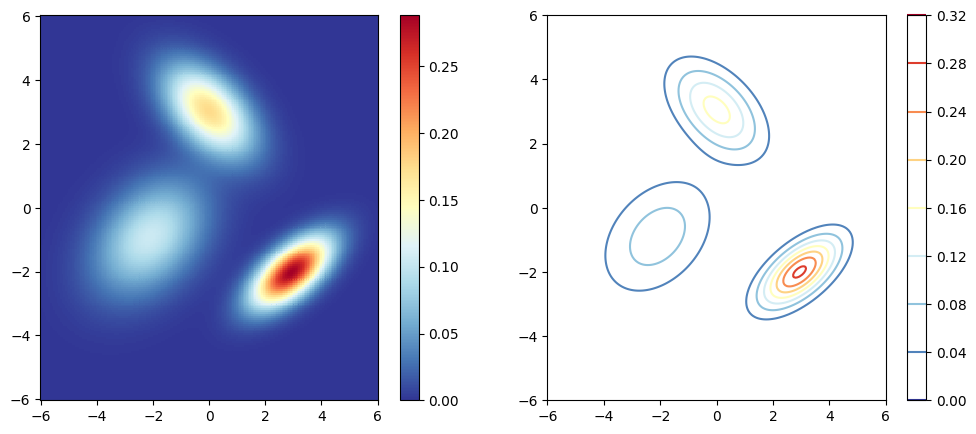

In [300]:
z = 0
for k in range(K):
    z += multivariate_normal(mu[k], sigma[k]).pdf(pos)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.pcolor(posx, posy, z, cmap="RdYlBu_r")
plt.colorbar()

plt.subplot(122)
plt.contour(posx, posy, z, cmap="RdYlBu_r")
plt.colorbar()
plt.show()

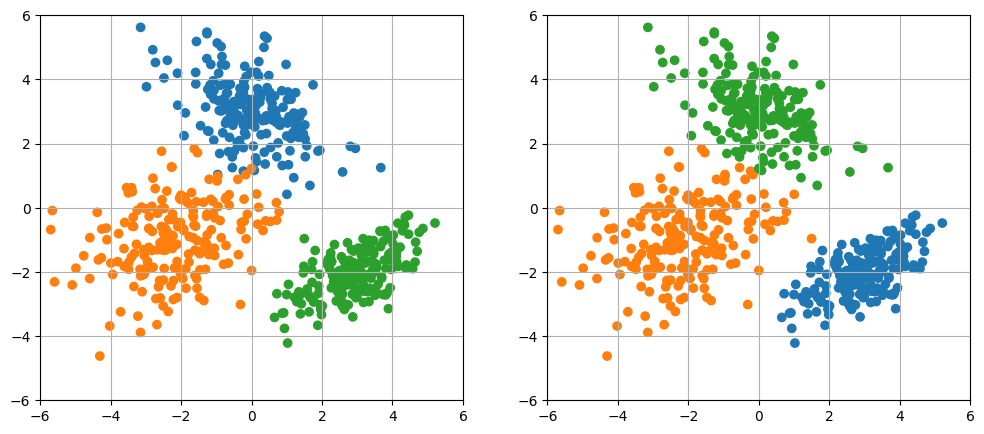

In [301]:
plt.figure(figsize=(12, 5))
# 正解ラベル
plt.subplot(121)
plt.scatter(data.loc[:,0], data.loc[:,1], color=matplotlib.cm.tab10(cluster_label.loc[:,0]))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid()

# 推定ラベル
plt.subplot(122)
estimated_label = gamma.idxmax(axis=1).values
plt.scatter(data.loc[:,0], data.loc[:,1], color=matplotlib.cm.tab10(estimated_label))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid()
# plt.legend()
plt.show()